In [1]:
%matplotlib inline


Transfer Learning for Computer Vision Tutorial
==============================================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at `cs231n notes <https://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [3]:
!pip install torchinfo
import torchinfo as torchinfo

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [4]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


#### Cargar aquí su dirección donde salvó los datos
Se debe suministrar la ruta de la carpeta "hymenoptera_data". El programa busca las carpetas `train` y `val` automáticamente.

In [5]:
data_dir = '/content/drive/My Drive/CIA_marcos/deep_learning/clase_8/transfer_learning/data/hymenoptera_data'

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



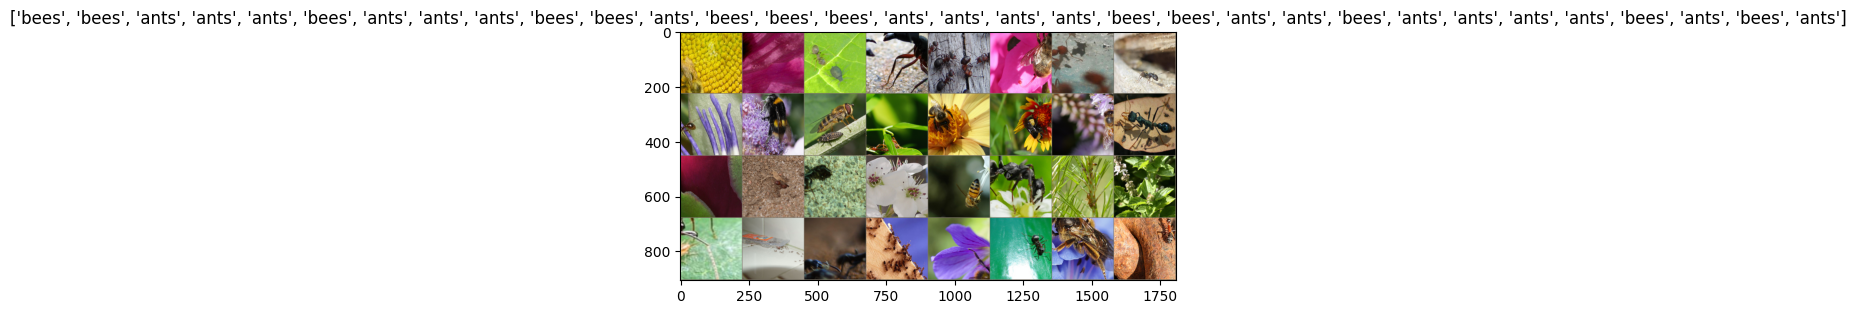

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.

![](https://drive.google.com/uc?export=view&id=1dckFaeLJobcWkh04wxiYBMo-GCllnQPj)





In [10]:
model_ft = models.resnet18(weights='DEFAULT')


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 150MB/s]


In [11]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
model_ft.fc

Linear(in_features=512, out_features=1000, bias=True)

In [13]:

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(512, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [14]:
model_ft


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [15]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=7)

Epoch 0/6
----------
train Loss: 0.6478 Acc: 0.6148
val Loss: 0.5336 Acc: 0.6993

Epoch 1/6
----------
train Loss: 0.4206 Acc: 0.8730
val Loss: 0.3517 Acc: 0.8824

Epoch 2/6
----------
train Loss: 0.3060 Acc: 0.8934
val Loss: 0.2501 Acc: 0.9150

Epoch 3/6
----------
train Loss: 0.2353 Acc: 0.9344
val Loss: 0.2170 Acc: 0.9216

Epoch 4/6
----------
train Loss: 0.1938 Acc: 0.9508
val Loss: 0.2039 Acc: 0.9412

Epoch 5/6
----------
train Loss: 0.1754 Acc: 0.9467
val Loss: 0.1890 Acc: 0.9412

Epoch 6/6
----------
train Loss: 0.1740 Acc: 0.9344
val Loss: 0.1816 Acc: 0.9412

Training complete in 1m 8s
Best val Acc: 0.941176


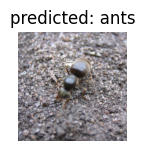

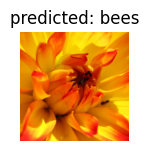

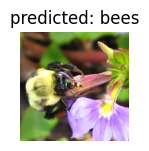

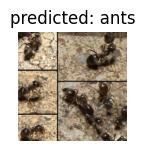

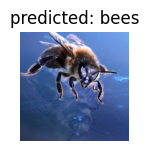

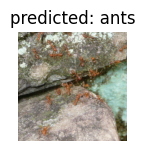

In [16]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.

![](https://drive.google.com/uc?export=view&id=1NeTWnzxmyQbZKnhfMiArtKx_kYwYBq-X)





In [17]:
model_conv = torchvision.models.resnet18(weights='DEFAULT')

for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)



model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
#optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [18]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=7)

Epoch 0/6
----------
train Loss: 0.6686 Acc: 0.5943
val Loss: 0.5308 Acc: 0.8170

Epoch 1/6
----------
train Loss: 0.5019 Acc: 0.7664
val Loss: 0.3884 Acc: 0.9085

Epoch 2/6
----------
train Loss: 0.3936 Acc: 0.8893
val Loss: 0.3130 Acc: 0.9216

Epoch 3/6
----------
train Loss: 0.2893 Acc: 0.9180
val Loss: 0.2605 Acc: 0.9608

Epoch 4/6
----------
train Loss: 0.2837 Acc: 0.9180
val Loss: 0.2393 Acc: 0.9346

Epoch 5/6
----------
train Loss: 0.2306 Acc: 0.9262
val Loss: 0.2204 Acc: 0.9477

Epoch 6/6
----------
train Loss: 0.2362 Acc: 0.9098
val Loss: 0.2151 Acc: 0.9346

Training complete in 0m 23s
Best val Acc: 0.960784


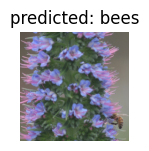

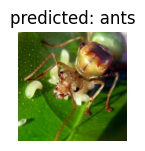

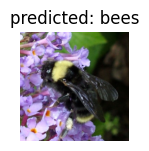

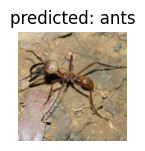

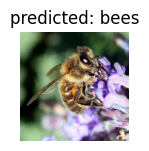

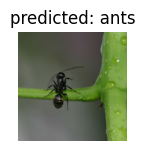

In [19]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## Feature extractor de menor profundidad

En este caso, tomamos un modelo pre-entrenado, pero no usamos la totalidad de su arquitectura (solamente nos quednamos con los primeros features).
Para eso, vamos a tener que modificar el modelo que descargamos y calcular bien el tamaño de los features que da como salida la última capa del modelo que empleemos.



![](https://drive.google.com/uc?export=view&id=11edHrMWWij92IR6h0x2HOv4uw2bAYvuY)




In [20]:
# Repasamos la arquitectura de modelo para definir donde "cortar"
# También vemos el tamaño de las imagen que vamos a procesar

# me descargo solo el modelo, sin entrenar
resnet18 = torchvision.models.resnet18()

child_counter = 0
for child in resnet18.children():
   print(" ---- child ---- ", child_counter, "is:")
   print(child)
   child_counter += 1

print()
print('tamaño del batch (tamaño de las imagenes a procesar):')
print(inputs.shape)

 ---- child ----  0 is:
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
 ---- child ----  1 is:
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ---- child ----  2 is:
ReLU(inplace=True)
 ---- child ----  3 is:
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
 ---- child ----  4 is:
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [21]:
# Estudiemos el modelo con un input de 32 imágenes, de 3 canales y de 224x224 pixeles
torchinfo.summary(resnet18, input_size=( 32, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 1000]                --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│

In [26]:
# nueva clase para mi nuevo modelo de CNN

class MyCustomResnet18(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()

        resnet18 = models.resnet18(weights='DEFAULT')
        # tomamos las capas deseadas para que hagan de "feature extractor"
        # las contamos desde el final de la red hacia el principio
        self.features = nn.ModuleList(resnet18.children())[:-4]

        # ahora, con el Sequential, pasamos el listado armado
        # para que nos implemente el paso forward de dicho listado ya que
        # el ModuleList no lo hace.
        # De esta manera, podremos pasar las imágenes a fixed_feature(images)
        # para que aplica las primeras capas que tomamos del transfer learning
        # como feature extractor
        self.fixed_features = nn.Sequential(*self.features)

        # agregamos nuestras capas de salida según necesidad
        # pero antes......
        # hay que calcular el número de features que saca nuestra última capa!
        # para eso estudiamos las celdas de antes con la función summary
        in_features = 28*28*128 # [hor x ver x chan]

        # ahora si, colocamos las capas deseadas del clasificador final
        # OJO! también puedo colocar más capas de convolución o lo que desee,
        # como por ejemplo, una AdaptiveAvgPool2d
        self.fc0 = nn.Linear(in_features, 256)
        self.fc0_bn = nn.BatchNorm1d(256, eps = 1e-2)
        self.fc1 = nn.Linear(256, 2)
        self.fc1_bn = nn.BatchNorm1d(2, eps = 1e-2)

        # initialize all fc layers to xavier (esto es opcional)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight, gain = 1)

    def forward(self, input_imgs):
        # now in forward pass, you have the full control,
        # we can use the feature part from our pretrained model  like this
        output = self.fixed_features(input_imgs)
        # since we are using fc layers from now on, we need to flatten the output.
        # we used the avgpooling but we still need to flatten from the shape (batch, 1,1, features)
        # to (batch, features) so we reshape like this. input_imgs.size(0) gives the batchsize, and
        # we use -1 for inferring the rest
        output = output.view(input_imgs.size(0), -1)
        # and also our new layers.
        output = self.fc0_bn(torch.relu(self.fc0(output)))
        output = self.fc1_bn(torch.relu(self.fc1(output)))

        return output

In [27]:
# instanciamos el modelo desde cero y vemos que no tengamos problemas con las dimensiones
model_conv_ld = MyCustomResnet18()
# Estudiemos el modelo con un input de 12 imágenes, de 3 canales y de 224x224 pixeles
torchinfo.summary(model_conv_ld, input_size=( 12, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
MyCustomResnet18                              [12, 2]                   --
├─Sequential: 1-1                             [12, 128, 28, 28]         --
│    └─Conv2d: 2-1                            [12, 64, 112, 112]        9,408
│    └─BatchNorm2d: 2-2                       [12, 64, 112, 112]        128
│    └─ReLU: 2-3                              [12, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                         [12, 64, 56, 56]          --
│    └─Sequential: 2-5                        [12, 64, 56, 56]          --
│    │    └─BasicBlock: 3-1                   [12, 64, 56, 56]          73,984
│    │    └─BasicBlock: 3-2                   [12, 64, 56, 56]          73,984
│    └─Sequential: 2-6                        [12, 128, 28, 28]         --
│    │    └─BasicBlock: 3-3                   [12, 128, 28, 28]         230,144
│    │    └─BasicBlock: 3-4                   [12, 128, 28, 28]         295,42

In [28]:
# congelo los parámetros que no deseo entenar
# que serían la parte del modelo original
# o puedo hacer fine tunning... lo elijo según sea el caso.
for param in model_conv_ld.fixed_features.parameters():
    param.requires_grad = False


model_conv_ld = model_conv_ld.to(device)

criterion = nn.CrossEntropyLoss()

# definimos el optimizer, con los parámetros del modelo a entrenar
optimizer_conv_ld = optim.SGD(model_conv_ld.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv_ld, step_size=7, gamma=0.1)

Train and evaluate





In [29]:
model_conv = train_model(model_conv_ld, criterion, optimizer_conv_ld,
                         exp_lr_scheduler, num_epochs=7)

Epoch 0/6
----------
train Loss: 0.8098 Acc: 0.5820
val Loss: 0.6355 Acc: 0.6732

Epoch 1/6
----------
train Loss: 0.6037 Acc: 0.6680
val Loss: 0.6361 Acc: 0.7059

Epoch 2/6
----------
train Loss: 0.5395 Acc: 0.7008
val Loss: 0.5892 Acc: 0.7320

Epoch 3/6
----------
train Loss: 0.5051 Acc: 0.7418
val Loss: 0.5587 Acc: 0.7647

Epoch 4/6
----------
train Loss: 0.4832 Acc: 0.7787
val Loss: 0.5495 Acc: 0.7647

Epoch 5/6
----------
train Loss: 0.5021 Acc: 0.7090
val Loss: 0.5470 Acc: 0.7778

Epoch 6/6
----------
train Loss: 0.4640 Acc: 0.7869
val Loss: 0.5403 Acc: 0.7778

Training complete in 0m 23s
Best val Acc: 0.777778


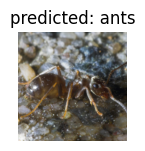

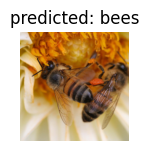

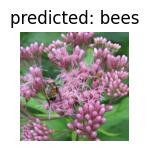

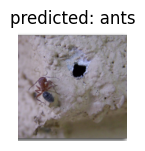

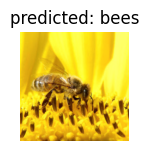

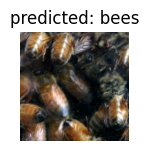

In [31]:
visualize_model(model_conv_ld)

plt.ioff()
plt.show()

Further Learning
-----------------

If you would like to learn more about the applications of transfer learning,
checkout our `Quantized Transfer Learning for Computer Vision Tutorial <https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html>`_.



